### Members:
- 109065511 張宜禎
- 109062562 蔡哲維
- 108065425 丘騏銘

# Importing

In [1]:
# inline plotting instead of popping out
%matplotlib inline

import os, itertools, timeit, re, ast, json
from datetime import datetime
from pytz import timezone

from IPython.display import Image
from IPython.display import display
import numpy as np
import pandas as pd
import scipy as sp
from bs4 import BeautifulSoup

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plt = matplotlib.pyplot

from tqdm import tqdm
tqdm.pandas()

In [3]:
# sklearn
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, LatentDirichletAllocation

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [5]:
dirname = './data'
f_train = 'train.csv'
f_test = 'test.csv'
f_sub = 'sample_submission.csv'
p_train = os.path.join(dirname, f_train)
p_test = os.path.join(dirname, f_test)
p_sub = os.path.join(dirname, f_sub)

In [6]:
df_train = pd.read_csv(p_train)
pop_group = df_train.groupby(['Popularity'])
df_train.head()

,Id,Popularity,Page content
0,0,-1,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."
2,2,1,"<html><head><div class=""article-info""><span cl..."
3,3,-1,"<html><head><div class=""article-info""><span cl..."
4,4,-1,"<html><head><div class=""article-info""><span cl..."


In [7]:
df_test = pd.read_csv(p_test)
df_test.head()

,Id,Page content
0,27643,"<html><head><div class=""article-info""><span cl..."
1,27644,"<html><head><div class=""article-info""><span cl..."
2,27645,"<html><head><div class=""article-info""><span cl..."
3,27646,"<html><head><div class=""article-info""><span cl..."
4,27647,"<html><head><div class=""article-info""><span cl..."


# Preprocessing

### Article Title

Title related features:
- Raw title (colname: `title`)
- Preprocessed title (colname: `title_p`)
- Number of tokens in title (colname: `title_len`)
- POS tag of the first 10 tokens of the title (colname: `title_pos_tag_1`, ... , `title_pos_tag_10`)

In [19]:
def clean_text(text_to_clean):
    """
    Text cleaning function
    
    Input: raw text (string)
    Output: cleaned text, all lowercase (string)
    """
    res = text_to_clean.lower()
    res = re.sub(r"i'm", "i am", res)
    res = re.sub(r"he's", "he is", res)
    res = re.sub(r"she's", "she is", res)
    res = re.sub(r"it's", "it is", res)
    res = re.sub(r"that's", "that is", res)
    res = re.sub(r"what's", "what is", res)
    res = re.sub(r"where's", "where is", res)
    res = re.sub(r"how's", "how is", res)
    res = re.sub(r"\'s", " is", res)
    res = re.sub(r"\'ll", " will", res)
    res = re.sub(r"\'ve", " have", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"\'d", " would", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"won't", "will not", res)
    res = re.sub(r"can't", "cannot", res)
    res = re.sub(r"n't", " not", res)
    res = re.sub(r"n'", "ng", res)
    res = re.sub(r"'bout", "about", res)
    res = re.sub(r"'til", "until", res)
    
    res = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", res)
    return res

In [20]:
stop_words = stopwords.words('english')

def preprocessor(text):
    """
    Text preprocessing function
    
    Input: raw text (string)
    Output: lemmatized and cleaned text, all lowercase, stopwords removed (string)
    """
    wnl = WordNetLemmatizer()
    res = clean_text(text)
    
    tokens = [wnl.lemmatize(w) for w in re.split('\s+', res.strip()) \
        if w not in stop_words and re.match('[a-zA-Z]+', w)]
    
    return ' '.join(tokens)

In [21]:
def get_title(content):
    """
    Extracts the h1 title from raw HTML code
    
    Input: raw HTML code (string)
    Output: h1 title (string)
    """
    soup = BeautifulSoup(content, 'html.parser')
    return soup.h1.string

In [22]:
df_train['title'] = df_train['Page content'].progress_apply(get_title)
df_test['title'] = df_test['Page content'].progress_apply(get_title)

100%|███████████████████████████████████████████████████████████████████████████| 11847/11847 [00:42<00:00, 280.44it/s]


In [23]:
def get_pos_tag_seq(s):
    """
    Gets POS tag of tokens (words) in the title
    
    Input: h1 title (string)
    Output: POS tags separated by a space (string)
    """
    tag_pair = pos_tag(word_tokenize((str(s))))
    tags = ""
    
    for s, tag in tag_pair:
        tags += tag + ' '
    return tags

In [24]:
df_train['title_pos_tag_seq'] = df_train['title'].progress_apply(get_pos_tag_seq)
df_test['title_pos_tag_seq'] = df_test['title'].progress_apply(get_pos_tag_seq)

100%|██████████████████████████████████████████████████████████████████████████| 11847/11847 [00:11<00:00, 1063.11it/s]


In [25]:
def get_title_pos_tag_cols(df):
    """
    Creates 12 columns:
        1. title_pos_tag_arr: POS tags of title in list format
        2. title_len: Title token length
        3-12. title_pos_tag_(n): POS tag of the nth position in the title tokens, up to the 10th position.
                                 If title tokens is less than 10, then fill the remaining columns with the 'NONE' tag.
                                 
    Input: Pandas dataframe with 'title_pos_tag_seq' column
    Output: None
    """
    def fill(arr, i):
        try:
            return arr[i]
        except:
            return 'NONE'
        
    start = timeit.default_timer()
    
    df['title_pos_tag_arr'] =  df['title_pos_tag_seq'].apply(lambda seq: seq.split()) 
    df['title_len'] =  df['title_pos_tag_seq'].apply(lambda seq: len(seq.split()))
    MAX_LEN = 10
        
    for i in range(MAX_LEN):
        col_name = 'title_pos_tag_{}'.format(i+1)
        df[col_name] = df['title_pos_tag_arr'].apply(lambda arr: fill(arr, i))

    stop = timeit.default_timer()
    print('Time: ', stop - start)  

In [26]:
get_title_pos_tag_cols(df_train)
get_title_pos_tag_cols(df_test)
df_train.drop(['title_pos_tag_arr', 'title_pos_tag_seq'], axis=1, inplace=True)
df_test.drop(['title_pos_tag_arr', 'title_pos_tag_seq'], axis=1, inplace=True)

Time:  0.12794139999994059
Time:  0.057520899999985886


In [31]:
df_train['title_p'] = df_train['title'].progress_apply(lambda s: preprocessor(s))
df_test['title_p'] = df_test['title'].progress_apply(lambda s: preprocessor(s))


100%|█████████████████████████████████████████████████████████████████████████| 11847/11847 [00:00<00:00, 16788.80it/s]

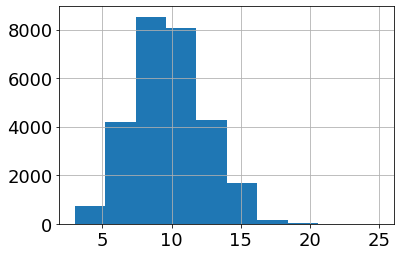

In [32]:
# plot title length distribution
df_train['title_len'].hist()

### Article Topics

Topic related features:
- Raw topics (colname: `topics`)
- Preprocessed title (colname: `topics_p`)
- Number of tokens in title (colname: `num_topics`)

In [33]:
def get_topics(content):
    """
    Extract article topics from raw HTML code
    
    Input: raw HTML code (string)
    Output: article topics (List(string))
    """
    soup = BeautifulSoup(content, 'html.parser')
    topics = []
    for link in soup.footer.find_all('a'):
        topics.append(link.string)
    return topics

In [34]:
df_train['topics'] = df_train['Page content'].progress_apply(get_topics)
df_test['topics'] = df_test['Page content'].progress_apply(get_topics)


 15%|███████████▋                                                                | 4250/27643 [00:14<01:25, 273.11it/s]


 30%|██████████████████████▉                                                     | 8333/27643 [00:30<01:13, 262.09it/s]


 44%|████████████████████████████████▉                                          | 12126/27643 [00:49<01:05, 235.16it/s]


 58%|███████████████████████████████████████████▊                               | 16157/27643 [01:04<00:56, 201.71it/s]


 73%|██████████████████████████████████████████████████████▍                    | 20080/27643 [01:20<00:33, 228.33it/s]


 87%|█████████████████████████████████████████████████████████████████▎         | 24074/27643 [01:44<00:14, 243.97it/s]


  2%|█▋                                                                            | 253/11847 [00:01<04:14, 45.59it/s]


 36%|███████████████████████████▍                                                | 4284/11847 [00:16<00:31, 240.40it/s]


 70%|████████████████████████████████████████████████████▊                       | 8236/11847 [00:32<00:14, 257.33it/s]


100%|███████████████████████████████████████████████████████████████████████████| 11847/11847 [01:18<00:00, 151.01it/s]

In [42]:
type(df_train.loc[0, 'topics'])

list

In [43]:
df_train['topics_p'] = df_train['topics'].progress_apply(lambda arr: preprocessor(' '.join(arr)))
df_test['topics_p'] = df_test['topics'].progress_apply(lambda arr: preprocessor(' '.join(arr)))



  0%|                                                                                        | 0/27643 [00:00<?, ?it/s]

  2%|█▊                                                                          | 640/27643 [00:00<00:04, 6360.65it/s]

  6%|████▋                                                                      | 1744/27643 [00:00<00:03, 7280.29it/s]

 11%|███████▉                                                                   | 2917/27643 [00:00<00:03, 8205.68it/s]

 15%|███████████▏                                                               | 4141/27643 [00:00<00:02, 9095.38it/s]

 19%|█████████████▉                                                             | 5138/27643 [00:00<00:02, 9328.02it/s]

 23%|█████████████████                                                         | 6363/27643 [00:00<00:02, 10033.35it/s]

 28%|████████████████████▋                                                     | 7739/27643 [00:00<00:01, 10907.54it/s]

 32%|███████████████████████▉ 

In [46]:
df_train['num_topics'] = df_train['topics'].apply(lambda arr: len(arr))
df_test['num_topics'] = df_test['topics'].apply(lambda arr: len(arr))

### Article Content

Article related features:
- Article content (colname: `article`)
- Number of tokens in article (colname: `article_len`)

In [47]:
def get_article(content):
    """
    Extract article content from raw HTML code (excluding "SEE ALSO" and "Image Courtesy" parts of the article)
    
    Input: raw HTML code (string)
    Output: article content (string)
    """
    soup = BeautifulSoup(content, 'html.parser')
    article = ' '.join([str(item) for item in soup.find_all('p')])
    article = re.sub('<\s*\/\s*p\s*>', '\n', article) 
    article = re.sub('<\s*br\s*\/\s*>', '\n', article)
    article = re.sub('<[^>]*>', '', article)
    fin = [x for x in article.split('\n') if x and not re.search('see also', x.lower()) and not (re.search('image courtesy', x.lower()))]
    return '\n'.join(fin)

In [48]:
df_train['article'] = df_train['Page content'].progress_apply(get_article)
df_test['article'] = df_test['Page content'].progress_apply(get_article)



  0%|                                                                                        | 0/27643 [00:00<?, ?it/s]

  0%|                                                                              | 1/27643 [00:00<4:00:49,  1.91it/s]

  0%|                                                                             | 19/27643 [00:00<2:49:14,  2.72it/s]

  0%|▏                                                                            | 45/27643 [00:00<1:58:59,  3.87it/s]

  0%|▏                                                                            | 71/27643 [00:00<1:23:46,  5.49it/s]

  0%|▎                                                                              | 99/27643 [00:00<59:06,  7.77it/s]

  0%|▎                                                                             | 126/27643 [00:01<41:50, 10.96it/s]

  1%|▍                                                                             | 155/27643 [00:01<29:44, 15.40it/s]

  1%|▌                        

 14%|██████████▉                                                                 | 3963/27643 [00:15<01:32, 255.81it/s]

 14%|██████████▉                                                                 | 3995/27643 [00:15<01:27, 271.81it/s]

 15%|███████████                                                                 | 4023/27643 [00:15<01:36, 245.63it/s]

 15%|███████████▏                                                                | 4062/27643 [00:15<01:25, 274.81it/s]

 15%|███████████▎                                                                | 4092/27643 [00:15<01:30, 261.55it/s]

 15%|███████████▎                                                                | 4126/27643 [00:15<01:23, 280.66it/s]

 15%|███████████▍                                                                | 4156/27643 [00:15<01:30, 259.69it/s]

 15%|███████████▌                                                                | 4186/27643 [00:15<01:27, 269.50it/s]

 15%|███████████▌               

 28%|████████████████████▉                                                       | 7636/27643 [00:30<01:15, 265.32it/s]

 28%|█████████████████████                                                       | 7665/27643 [00:30<01:13, 271.12it/s]

 28%|█████████████████████▏                                                      | 7693/27643 [00:30<01:14, 266.80it/s]

 28%|█████████████████████▏                                                      | 7721/27643 [00:30<01:17, 255.76it/s]

 28%|█████████████████████▎                                                      | 7753/27643 [00:30<01:13, 271.87it/s]

 28%|█████████████████████▍                                                      | 7781/27643 [00:30<01:16, 259.33it/s]

 28%|█████████████████████▍                                                      | 7811/27643 [00:31<01:14, 266.41it/s]

 28%|█████████████████████▌                                                      | 7842/27643 [00:31<01:11, 277.69it/s]

 28%|█████████████████████▋     

 42%|███████████████████████████████▎                                           | 11522/27643 [00:45<01:03, 253.77it/s]

 42%|███████████████████████████████▎                                           | 11548/27643 [00:45<01:05, 246.23it/s]

 42%|███████████████████████████████▍                                           | 11573/27643 [00:45<01:08, 233.46it/s]

 42%|███████████████████████████████▍                                           | 11605/27643 [00:45<01:03, 252.57it/s]

 42%|███████████████████████████████▌                                           | 11638/27643 [00:45<01:00, 265.43it/s]

 42%|███████████████████████████████▋                                           | 11671/27643 [00:45<00:57, 278.82it/s]

 42%|███████████████████████████████▋                                           | 11702/27643 [00:46<00:56, 280.97it/s]

 42%|███████████████████████████████▊                                           | 11731/27643 [00:46<01:05, 242.89it/s]

 43%|███████████████████████████

 55%|█████████████████████████████████████████▍                                 | 15271/27643 [01:00<00:53, 232.17it/s]

 55%|█████████████████████████████████████████▌                                 | 15297/27643 [01:00<00:51, 238.24it/s]

 55%|█████████████████████████████████████████▌                                 | 15322/27643 [01:00<00:56, 218.42it/s]

 56%|█████████████████████████████████████████▋                                 | 15346/27643 [01:00<00:55, 223.55it/s]

 56%|█████████████████████████████████████████▋                                 | 15369/27643 [01:00<00:54, 223.18it/s]

 56%|█████████████████████████████████████████▊                                 | 15394/27643 [01:00<00:54, 225.98it/s]

 56%|█████████████████████████████████████████▊                                 | 15419/27643 [01:01<00:53, 230.48it/s]

 56%|█████████████████████████████████████████▉                                 | 15450/27643 [01:01<00:49, 245.60it/s]

 56%|███████████████████████████

 69%|███████████████████████████████████████████████████▊                       | 19099/27643 [01:15<00:30, 281.04it/s]

 69%|███████████████████████████████████████████████████▉                       | 19128/27643 [01:15<00:31, 266.94it/s]

 69%|███████████████████████████████████████████████████▉                       | 19161/27643 [01:15<00:30, 274.52it/s]

 69%|████████████████████████████████████████████████████                       | 19190/27643 [01:15<00:30, 278.90it/s]

 70%|████████████████████████████████████████████████████▏                      | 19219/27643 [01:16<00:30, 273.18it/s]

 70%|████████████████████████████████████████████████████▏                      | 19249/27643 [01:16<00:30, 279.51it/s]

 70%|████████████████████████████████████████████████████▎                      | 19278/27643 [01:16<00:29, 279.72it/s]

 70%|████████████████████████████████████████████████████▍                      | 19310/27643 [01:16<00:28, 290.68it/s]

 70%|███████████████████████████

 83%|██████████████████████████████████████████████████████████████▍            | 23000/27643 [01:30<00:16, 281.66it/s]

 83%|██████████████████████████████████████████████████████████████▍            | 23029/27643 [01:30<00:17, 269.76it/s]

 83%|██████████████████████████████████████████████████████████████▌            | 23057/27643 [01:30<00:18, 250.90it/s]

 84%|██████████████████████████████████████████████████████████████▋            | 23087/27643 [01:30<00:17, 263.78it/s]

 84%|██████████████████████████████████████████████████████████████▋            | 23114/27643 [01:31<00:18, 244.99it/s]

 84%|██████████████████████████████████████████████████████████████▊            | 23143/27643 [01:31<00:17, 256.60it/s]

 84%|██████████████████████████████████████████████████████████████▉            | 23176/27643 [01:31<00:16, 270.24it/s]

 84%|██████████████████████████████████████████████████████████████▉            | 23205/27643 [01:31<00:16, 274.65it/s]

 84%|███████████████████████████

 98%|█████████████████████████████████████████████████████████████████████████▎ | 27025/27643 [01:45<00:02, 273.43it/s]

 98%|█████████████████████████████████████████████████████████████████████████▍ | 27053/27643 [01:45<00:02, 269.14it/s]

 98%|█████████████████████████████████████████████████████████████████████████▍ | 27081/27643 [01:45<00:02, 268.00it/s]

 98%|█████████████████████████████████████████████████████████████████████████▌ | 27111/27643 [01:45<00:01, 273.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████▋ | 27139/27643 [01:45<00:01, 268.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████▋ | 27170/27643 [01:45<00:01, 277.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████▊ | 27198/27643 [01:45<00:01, 254.21it/s]

 98%|█████████████████████████████████████████████████████████████████████████▊ | 27224/27643 [01:46<00:01, 248.40it/s]

 99%|███████████████████████████

 27%|████████████████████▊                                                       | 3238/11847 [00:12<00:36, 233.87it/s]

 28%|████████████████████▉                                                       | 3266/11847 [00:12<00:34, 245.36it/s]

 28%|█████████████████████                                                       | 3292/11847 [00:13<00:35, 243.71it/s]

 28%|█████████████████████▎                                                      | 3317/11847 [00:13<00:35, 242.85it/s]

 28%|█████████████████████▍                                                      | 3347/11847 [00:13<00:33, 253.99it/s]

 28%|█████████████████████▋                                                      | 3373/11847 [00:13<00:34, 243.43it/s]

 29%|█████████████████████▊                                                      | 3407/11847 [00:13<00:31, 265.76it/s]

 29%|██████████████████████                                                      | 3437/11847 [00:13<00:30, 273.31it/s]

 29%|██████████████████████▏    

 60%|█████████████████████████████████████████████▌                              | 7103/11847 [00:27<00:20, 231.22it/s]

 60%|█████████████████████████████████████████████▊                              | 7132/11847 [00:27<00:19, 245.25it/s]

 60%|█████████████████████████████████████████████▉                              | 7158/11847 [00:27<00:21, 214.45it/s]

 61%|██████████████████████████████████████████████                              | 7190/11847 [00:28<00:19, 234.16it/s]

 61%|██████████████████████████████████████████████▎                             | 7225/11847 [00:28<00:17, 258.53it/s]

 61%|██████████████████████████████████████████████▌                             | 7254/11847 [00:28<00:17, 266.71it/s]

 62%|██████████████████████████████████████████████▊                             | 7290/11847 [00:28<00:15, 287.49it/s]

 62%|███████████████████████████████████████████████                             | 7327/11847 [00:28<00:14, 307.70it/s]

 62%|███████████████████████████

 94%|██████████████████████████████████████████████████████████████████████▌    | 11140/11847 [00:42<00:03, 215.68it/s]

 94%|██████████████████████████████████████████████████████████████████████▋    | 11163/11847 [00:42<00:03, 219.45it/s]

 95%|██████████████████████████████████████████████████████████████████████▉    | 11199/11847 [00:42<00:02, 248.27it/s]

 95%|███████████████████████████████████████████████████████████████████████    | 11226/11847 [00:43<00:02, 238.90it/s]

 95%|███████████████████████████████████████████████████████████████████████▏   | 11252/11847 [00:43<00:02, 243.81it/s]

 95%|███████████████████████████████████████████████████████████████████████▍   | 11282/11847 [00:43<00:02, 257.98it/s]

 95%|███████████████████████████████████████████████████████████████████████▌   | 11309/11847 [00:43<00:02, 252.82it/s]

 96%|███████████████████████████████████████████████████████████████████████▊   | 11336/11847 [00:43<00:02, 252.39it/s]

 96%|███████████████████████████

In [49]:
df_train['article_len'] = df_train['article'].progress_apply(lambda s: len(str(s).split()))
df_test['article_len'] = df_test['article'].progress_apply(lambda s: len(str(s).split()))



  0%|                                                                                        | 0/27643 [00:00<?, ?it/s]

 13%|█████████▊                                                                | 3666/27643 [00:00<00:00, 36557.80it/s]

 27%|████████████████████▎                                                     | 7567/27643 [00:00<00:00, 37239.82it/s]

 42%|██████████████████████████████▉                                          | 11722/27643 [00:00<00:00, 38340.43it/s]

 57%|█████████████████████████████████████████▊                               | 15835/27643 [00:00<00:00, 39130.47it/s]

 72%|████████████████████████████████████████████████████▏                    | 19765/27643 [00:00<00:00, 39119.32it/s]

 85%|██████████████████████████████████████████████████████████████▏          | 23546/27643 [00:00<00:00, 38654.57it/s]

100%|████████████████████████████████████████████████████████████████████████▊| 27574/27643 [00:00<00:00, 39127.78it/s]

100%|█████████████████████████

### Data channel

Similar to `topics`, but each article has only one `data_channel` hidden in the HTML code.

In [63]:
def get_data_channel(content):
    """
    Extract data channel from raw HTML code
    
    Input: raw HTML code (string)
    Output: data channel (string)
    """
    soup = BeautifulSoup(content, 'html.parser')
    return soup.article['data-channel']

In [64]:
df_train['data_channel'] = df_train['Page content'].progress_apply(get_data_channel)
df_test['data_channel'] = df_test['Page content'].progress_apply(get_data_channel)



  0%|                                                                                        | 0/27643 [00:00<?, ?it/s]

  0%|                                                                              | 29/27643 [00:00<01:37, 281.96it/s]

  0%|▏                                                                             | 58/27643 [00:00<01:37, 282.26it/s]

  0%|▏                                                                             | 87/27643 [00:00<01:36, 284.49it/s]

  0%|▎                                                                            | 117/27643 [00:00<01:37, 282.54it/s]

  1%|▍                                                                            | 153/27643 [00:00<01:31, 300.66it/s]

  1%|▌                                                                            | 182/27643 [00:00<01:32, 295.95it/s]

  1%|▌                                                                            | 212/27643 [00:00<01:32, 296.61it/s]

  1%|▋                        

 16%|████████████▎                                                               | 4473/27643 [00:14<01:15, 306.29it/s]

 16%|████████████▍                                                               | 4505/27643 [00:14<01:20, 287.02it/s]

 16%|████████████▍                                                               | 4537/27643 [00:14<01:21, 284.93it/s]

 17%|████████████▌                                                               | 4568/27643 [00:15<01:19, 291.18it/s]

 17%|████████████▋                                                               | 4598/27643 [00:15<01:18, 292.48it/s]

 17%|████████████▋                                                               | 4628/27643 [00:15<01:18, 293.36it/s]

 17%|████████████▊                                                               | 4658/27643 [00:15<01:26, 267.20it/s]

 17%|████████████▉                                                               | 4693/27643 [00:15<01:21, 283.04it/s]

 17%|█████████████              

 32%|████████████████████████▏                                                   | 8816/27643 [00:29<00:59, 315.77it/s]

 32%|████████████████████████▎                                                   | 8849/27643 [00:29<01:06, 283.66it/s]

 32%|████████████████████████▍                                                   | 8883/27643 [00:29<01:03, 297.69it/s]

 32%|████████████████████████▌                                                   | 8914/27643 [00:30<01:06, 280.48it/s]

 32%|████████████████████████▌                                                   | 8943/27643 [00:30<01:06, 281.61it/s]

 32%|████████████████████████▋                                                   | 8981/27643 [00:30<01:01, 302.80it/s]

 33%|████████████████████████▊                                                   | 9021/27643 [00:30<00:57, 323.87it/s]

 33%|████████████████████████▉                                                   | 9055/27643 [00:30<00:58, 318.87it/s]

 33%|████████████████████████▉  

 48%|███████████████████████████████████▉                                       | 13237/27643 [00:44<00:56, 255.45it/s]

 48%|████████████████████████████████████                                       | 13273/27643 [00:44<00:51, 278.70it/s]

 48%|████████████████████████████████████                                       | 13308/27643 [00:44<00:48, 296.80it/s]

 48%|████████████████████████████████████▏                                      | 13340/27643 [00:45<00:47, 301.92it/s]

 48%|████████████████████████████████████▎                                      | 13375/27643 [00:45<00:45, 314.13it/s]

 49%|████████████████████████████████████▍                                      | 13408/27643 [00:45<00:45, 309.91it/s]

 49%|████████████████████████████████████▍                                      | 13440/27643 [00:45<00:46, 302.40it/s]

 49%|████████████████████████████████████▌                                      | 13471/27643 [00:45<00:51, 277.43it/s]

 49%|███████████████████████████

 64%|███████████████████████████████████████████████▊                           | 17644/27643 [00:59<00:35, 278.26it/s]

 64%|███████████████████████████████████████████████▉                           | 17682/27643 [00:59<00:33, 294.63it/s]

 64%|████████████████████████████████████████████████                           | 17719/27643 [00:59<00:32, 308.79it/s]

 64%|████████████████████████████████████████████████▏                          | 17751/27643 [00:59<00:32, 303.79it/s]

 64%|████████████████████████████████████████████████▎                          | 17788/27643 [00:59<00:30, 319.77it/s]

 64%|████████████████████████████████████████████████▎                          | 17821/27643 [01:00<00:32, 305.63it/s]

 65%|████████████████████████████████████████████████▍                          | 17853/27643 [01:00<00:32, 305.87it/s]

 65%|████████████████████████████████████████████████▌                          | 17889/27643 [01:00<00:30, 319.57it/s]

 65%|███████████████████████████

 80%|███████████████████████████████████████████████████████████▉               | 22107/27643 [01:14<00:18, 293.86it/s]

 80%|████████████████████████████████████████████████████████████               | 22138/27643 [01:14<00:18, 297.21it/s]

 80%|████████████████████████████████████████████████████████████▏              | 22169/27643 [01:14<00:19, 285.12it/s]

 80%|████████████████████████████████████████████████████████████▏              | 22199/27643 [01:14<00:19, 281.06it/s]

 80%|████████████████████████████████████████████████████████████▎              | 22242/27643 [01:14<00:17, 311.43it/s]

 81%|████████████████████████████████████████████████████████████▍              | 22275/27643 [01:15<00:18, 296.68it/s]

 81%|████████████████████████████████████████████████████████████▌              | 22309/27643 [01:15<00:17, 301.80it/s]

 81%|████████████████████████████████████████████████████████████▌              | 22340/27643 [01:15<00:17, 300.87it/s]

 81%|███████████████████████████

 96%|████████████████████████████████████████████████████████████████████████▏  | 26600/27643 [01:29<00:03, 324.15it/s]

 96%|████████████████████████████████████████████████████████████████████████▎  | 26638/27643 [01:29<00:03, 328.55it/s]

 96%|████████████████████████████████████████████████████████████████████████▎  | 26672/27643 [01:29<00:03, 304.17it/s]

 97%|████████████████████████████████████████████████████████████████████████▍  | 26704/27643 [01:29<00:03, 299.83it/s]

 97%|████████████████████████████████████████████████████████████████████████▌  | 26740/27643 [01:29<00:02, 315.59it/s]

 97%|████████████████████████████████████████████████████████████████████████▋  | 26774/27643 [01:29<00:02, 321.16it/s]

 97%|████████████████████████████████████████████████████████████████████████▋  | 26812/27643 [01:30<00:02, 334.99it/s]

 97%|████████████████████████████████████████████████████████████████████████▊  | 26846/27643 [01:30<00:02, 331.16it/s]

 97%|███████████████████████████

 29%|██████████████████████▍                                                     | 3490/11847 [00:11<00:29, 286.06it/s]

 30%|██████████████████████▌                                                     | 3520/11847 [00:11<00:29, 282.39it/s]

 30%|██████████████████████▊                                                     | 3559/11847 [00:11<00:27, 306.36it/s]

 30%|███████████████████████                                                     | 3591/11847 [00:11<00:27, 301.68it/s]

 31%|███████████████████████▎                                                    | 3627/11847 [00:11<00:26, 308.70it/s]

 31%|███████████████████████▍                                                    | 3659/11847 [00:11<00:26, 304.57it/s]

 31%|███████████████████████▋                                                    | 3690/11847 [00:12<00:27, 293.01it/s]

 31%|███████████████████████▊                                                    | 3720/11847 [00:12<00:30, 269.07it/s]

 32%|████████████████████████   

 66%|██████████████████████████████████████████████████▏                         | 7824/11847 [00:26<00:13, 297.92it/s]

 66%|██████████████████████████████████████████████████▍                         | 7857/11847 [00:26<00:13, 305.16it/s]

 67%|██████████████████████████████████████████████████▋                         | 7892/11847 [00:26<00:12, 316.89it/s]

 67%|██████████████████████████████████████████████████▉                         | 7932/11847 [00:26<00:11, 335.02it/s]

 67%|███████████████████████████████████████████████████                         | 7967/11847 [00:26<00:13, 292.06it/s]

 68%|███████████████████████████████████████████████████▎                        | 7998/11847 [00:26<00:13, 294.44it/s]

 68%|███████████████████████████████████████████████████▌                        | 8033/11847 [00:27<00:12, 308.73it/s]

 68%|███████████████████████████████████████████████████▊                        | 8071/11847 [00:27<00:11, 325.87it/s]

 68%|███████████████████████████

### Special URLs

Special URL features:
- Number of YouTube URLs (colname: `num_yt_link`)
- Number of Instagram URLs (colname: `num_ig`)
- Number of Twitter Tweets (colname: `num_tweet`)

In [52]:
s = "www.youtube.com/embed"
df_train['num_yt_link'] = df_train['Page content'].progress_apply(lambda c: c.count(s))
df_test['num_yt_link'] = df_test['Page content'].progress_apply(lambda c: c.count(s))



  0%|                                                                                        | 0/27643 [00:00<?, ?it/s]

 42%|██████████████████████████████▎                                         | 11640/27643 [00:00<00:00, 115754.87it/s]

100%|████████████████████████████████████████████████████████████████████████| 27643/27643 [00:00<00:00, 147514.12it/s]

  0%|                                                                                        | 0/11847 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████| 11847/11847 [00:00<00:00, 157640.18it/s]

In [53]:
s = "instagram.com"
df_train['num_ig'] = df_train['Page content'].progress_apply(lambda c: c.count(s))
df_test['num_ig'] = df_test['Page content'].progress_apply(lambda c: c.count(s))



  0%|                                                                                        | 0/27643 [00:00<?, ?it/s]

 52%|█████████████████████████████████████▏                                  | 14281/27643 [00:00<00:00, 142020.85it/s]

100%|████████████████████████████████████████████████████████████████████████| 27643/27643 [00:00<00:00, 142325.27it/s]

  0%|                                                                                        | 0/11847 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████| 11847/11847 [00:00<00:00, 129131.14it/s]

In [54]:
s = 'class=\"twitter-tweet\"'
df_train['num_tweet'] = df_train['Page content'].progress_apply(lambda c: c.count(s))
df_test['num_tweet'] = df_test['Page content'].progress_apply(lambda c: c.count(s))



  0%|                                                                                        | 0/27643 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████                        | 18441/27643 [00:00<00:00, 183442.73it/s]

100%|████████████████████████████████████████████████████████████████████████| 27643/27643 [00:00<00:00, 181520.52it/s]

  0%|                                                                                        | 0/11847 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████| 11847/11847 [00:00<00:00, 181092.97it/s]

### Article Date/Time

Date/Time features:
- Year (colname: `p_year`)
- Month (colname: `p_month`)
- Day (colname: `p_day`)
- Hour (colname: `p_hour`)
- Minute (colname: `p_minute`)
- Second (colname: `p_second`)
- Weekday: 0 is Monday, ..., 6 is Sunday (colname: `p_weekday`) 

In [10]:
def get_public_datetime(content):
    """
    Extract date/time from raw HTML code
    
    Input: raw HTML code
    Output: article published time
    """
    soup = BeautifulSoup(content, 'html.parser')
    
    t = soup.time
    try:
        dt = datetime.strptime(t['datetime'], '%a, %d %b %Y %H:%M:%S %z')
    except:
        dt = datetime(2013, 12, 29)
    dt = dt.astimezone(timezone('US/Pacific'))

    return dt

In [11]:
def populate_public_time_data(df):
    """
    Create year, month, day, hour, minute, second, weekday and week of year columns from raw HTML code.
    
    Input: Pandas dataframe
    Output: none
    """
    start = timeit.default_timer()
    
    for idx, r in df.iterrows():
        dt = get_public_datetime(r['Page content'])

        df.loc[idx, 'p_year'] = dt.year
        df.loc[idx, 'p_month'] = dt.month
        df.loc[idx, 'p_day'] = dt.day
        df.loc[idx, 'p_hour'] = dt.hour
        df.loc[idx, 'p_minute'] = dt.minute
        df.loc[idx, 'p_second'] = dt.second
        df.loc[idx, 'p_weekday'] = dt.weekday()
        df.loc[idx, 'p_week_of_year'] = dt.isocalendar()[1]
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  

In [12]:
populate_public_time_data(df_train)

Time:  176.7460046


In [13]:
populate_public_time_data(df_test)

Time:  71.73717260000001


In [15]:
time_col

['p_year',
 'p_month',
 'p_day',
 'p_hour',
 'p_minute',
 'p_second',
 'p_weekday',
 'p_week_of_year',
 'p_day_of_year']

In [17]:
df_test.drop(['p_day_of_year'], axis=1, inplace=True) # day_of_year not used

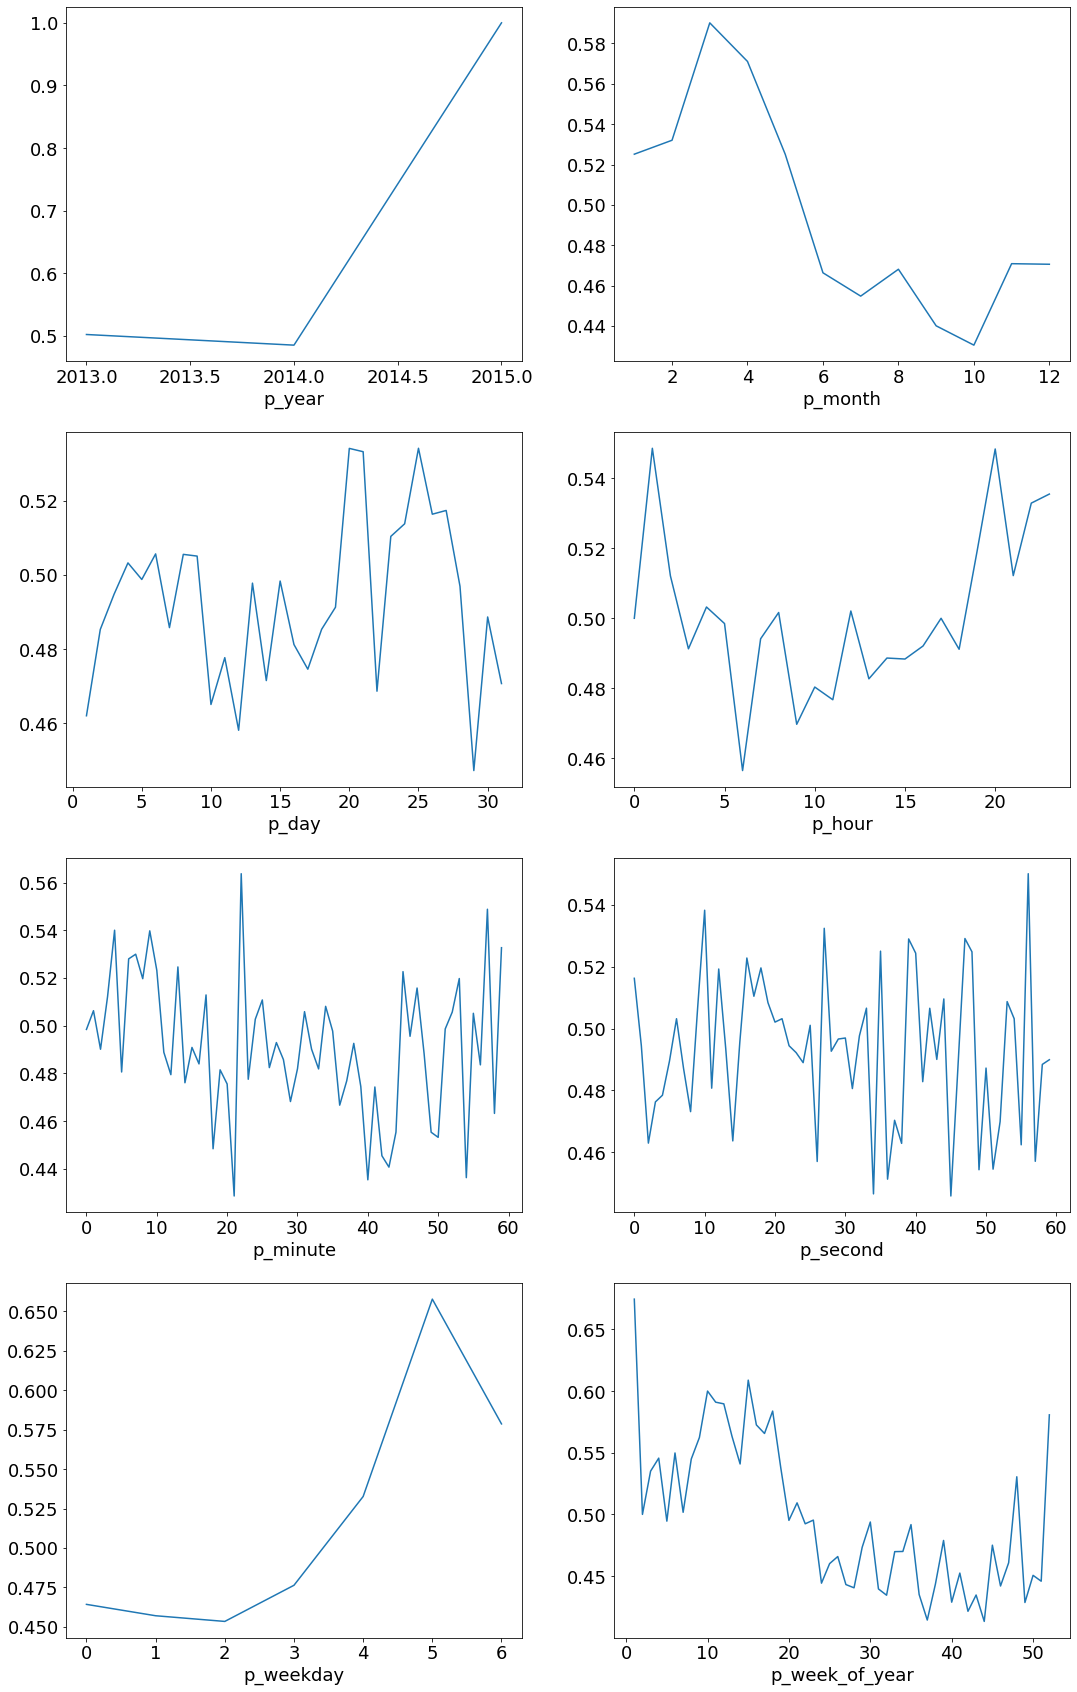

In [18]:
"""
Time features vs. Popularity graph
"""

time_col = [col for col in df_train.columns if 'p_' in col]

_, subplot_arr = plt.subplots(4, 2, figsize=(18, 30))

for idx, col in enumerate(time_col):
    col_group = df_train.groupby(col)
    
    time_idx = []
    popularity = []
    for name, group in col_group:
        pop = (group['Popularity'] == 1).sum()
        n_pop = (group['Popularity'] == -1).sum()

        time_idx.append(name)
        popularity.append(float(pop / (pop + n_pop)))
    
    subplot = subplot_arr[idx//2, idx%2]
    subplot.plot(time_idx, popularity)
    subplot.set_xlabel(col)

### Author features

- Author (colname: `author`)

In [21]:
def get_author(df):
    """
    Extract author feature from raw HTML
    
    Input: Pandas dataframe
    Output: None
    """
    article_info = []
    html_text = df['Page content'].tolist()
    for html in html_text:
        combine_strings = ''
        soup = BeautifulSoup(html,'html.parser')
        div_tag = soup.findAll('div', class_='article-info')
        for string in div_tag[0].strings:
            combine_strings = combine_strings + str(string) + '|'
        combine_strings = combine_strings.replace('\n','')
        article_info.append(combine_strings)

    author_list = []
    for info in article_info:
        if info[:4] == 'By |':
            split_res = info.split('|')
            author_list.append(split_res[1].strip())
        elif info[:2] == 'By':
            split_res = info.split('|')
            author_list.append(split_res[0].split('By')[1].strip())
        else:
            split_res = info.split('|')
            author_list.append(split_res[1].strip())

    df['author'] = author_list

In [23]:
get_author(df_train)
get_author(df_test)

### Scalar Features

In this competition, we find out that the words in news articles are hard to use.

So, we focus on finding other feature generating methods. One of the method is generating scalars.

For generating scalar, we calculate the ratio <font color=#008000>*(number of news whose popularity = 1) / (number of news)*</font> for each:


- <font color=#800080>author</font>
- <font color=#800080>words in topic</font>
- <font color=#800080>words in title</font>


#### Generating author scalar

In [8]:
class AuthorScalarGen(object):
    def __init__(self, threshold=30):
        self.scalar_dict = {}
        self.threshold=threshold
    def fit_transform(self, X, y=None, **fit_params):
        train = X.copy()
        for row_idx in range(X.shape[0]):
            if train.loc[row_idx,'author'][0:3] == "By ":
                train.loc[row_idx,'author'] = train.loc[row_idx,'author'].split("By ")[1]
            elif train.loc[row_idx,'author'][0:3] == "by ":
                train.loc[row_idx,'author'] = train.loc[row_idx,'author'].split("by ")[1]
            else:
                pass
            
        name_pos_times_dict = {}
        name_neg_times_dict = {}

        for row_idx in range(train.shape[0]):
            name_list = re.split('(, )|( & )|( and )',train.loc[row_idx,'author'])
            for name in name_list:
                if (name != ', ') and (name != ' & ') and (name != ' and ') and (name != None):
                    if name == 'Brian Ries *':
                        name = 'Brian Ries'
                    if train.loc[row_idx,'Popularity'] == 1 and name in name_pos_times_dict:
                        name_pos_times_dict[name] = name_pos_times_dict[name] + 1
                    elif train.loc[row_idx,'Popularity'] == 1 and name not in name_pos_times_dict:
                        name_pos_times_dict[name] = 1
                    elif train.loc[row_idx,'Popularity'] == -1 and name in name_neg_times_dict:
                        name_neg_times_dict[name] = name_neg_times_dict[name] + 1
                    elif train.loc[row_idx,'Popularity'] == -1 and name not in name_neg_times_dict:
                        name_neg_times_dict[name] = 1
                    else:
                        pass
                
        for key in name_pos_times_dict:
            if key in name_neg_times_dict and name_pos_times_dict[key] + name_neg_times_dict[key] > self.threshold:
                self.scalar_dict[key] = name_pos_times_dict[key] / (name_pos_times_dict[key] + name_neg_times_dict[key])
            elif key in name_neg_times_dict and name_pos_times_dict[key] + name_neg_times_dict[key] <= self.threshold:
                self.scalar_dict[key] = 0.5
            elif key not in name_neg_times_dict and name_pos_times_dict[key] > self.threshold:
                self.scalar_dict[key] = 1
            elif key not in name_neg_times_dict and name_pos_times_dict[key] <= self.threshold:
                self.scalar_dict[key] = 0.5
            else:
                pass

        for key in name_neg_times_dict:
            if key not in name_pos_times_dict and name_neg_times_dict[key] > self.threshold:
                self.scalar_dict[key] = 0
            elif key not in name_pos_times_dict and name_neg_times_dict[key] <= self.threshold:
                self.scalar_dict[key] = 0.5
            else:
                pass
            
        for row_idx in range(train.shape[0]):
            name_list = re.split('(, )|( & )|( and )',train.loc[row_idx,'author'])
            scalar = 0
            name_num = 0
            for name in name_list:
                if (name != ', ') and (name != ' & ') and (name != ' and ') and (name != None):
                    if name == 'Brian Ries *':
                        name = 'Brian Ries'
                    name_num = name_num + 1
                    try:
                        scalar = scalar + self.scalar_dict[name]
                    except KeyError:
                        print(name_pos_times_dict[name])
            scalar = scalar / name_num
            train.loc[row_idx,'author_scalar'] = scalar
        return train
    def transform(self, df, **transform_params):
        test = df.copy()
        for row_idx in range(test.shape[0]):
            name_list = re.split('(, )|( & )|( and )',test.loc[row_idx,'author'])
            scalar = 0
            name_num = 0
            for name in name_list:
                if (name != ', ') and (name != ' & ') and (name != ' and ') and (name != None):
                    if name == 'Brian Ries *':
                        name = 'Brian Ries'
                    name_num = name_num + 1
                    if name in self.scalar_dict:
                        scalar = scalar + self.scalar_dict[name]
                    else:
                        scalar = scalar + 0.5
            scalar = scalar / name_num
            test.loc[row_idx,'author_scalar'] = scalar
        return test

In the AuthorScalarGen, the __init__ function takes threshold as parameter. 

Threshold is the parameter to decide at least how many articles should a author writes, such that his or her the statistic popular ratio <font color=#008000>*(number of news whose popularity = 1/ number of news)*</font> is regarded as an effective statistic value. 

Otherwise, we assign the author scalar = 0.5.

The __fit_transform__ function takes the train dataframe, tries to generate an author-scalar-dictionary from the train dataframe, and map the authors in the dataframe to the scalars with author-scalar-dictionary.

The __transform__ function takes the validation/test dataframe and tries to map the authors in the dataframe to the scalars with author-scalar-dictionary generated in __fit_tansform__ step.

Something is interesting since an article can be written by multiple authors. So, in the code, we calculate the average scalar if the article is written by more than one authors.



For Example:
```
for name in name_list:
                if (name != ', ') and (name != ' & ') and (name != ' and ') and (name != None):
                    if name == 'Brian Ries *':
                        name = 'Brian Ries'
                    name_num = name_num + 1
                    try:
                        scalar = scalar + self.scalar_dict[name]
                    except KeyError:
                        print(name_pos_times_dict[name])
scalar = scalar / name_num
train.loc[row_idx,'author_scalar'] = scalar
```

#### Generating title and topic scalar

In [9]:
stemmer = SnowballStemmer('english')

def process_stem(content):
    a = content.split()
    b = []
    for i in a:
        b.append(stemmer.stem(i))
    return ' '.join(b)

custom_stopwords = list(set(stopwords.words('english') + process_stem(' '.join(stopwords.words('english'))).split()))

In [10]:
class bag_to_scalar(object):
    def __init__(self, column_name, threshold=30):
        self.vectorizer = CountVectorizer(stop_words = custom_stopwords, preprocessor = process_stem)
        self.threshold = threshold
        self.column_name = column_name
    def fit_transform(self, train_df):
        train_df_pos = train_df[train_df['Popularity'] == 1]
        train_df_neg = train_df[train_df['Popularity'] == -1]
        
        count_df_pos = pd.DataFrame(self.vectorizer.fit_transform(train_df_pos[column_name]).toarray(), 
                                    columns = self.vectorizer.get_feature_names())
        term_freq_pos = count_df_pos.sum()
        feature_name_pos = self.vectorizer.get_feature_names()
        term_freq_pos.reindex(feature_name_pos)
        
        count_df_neg = pd.DataFrame(self.vectorizer.fit_transform(train_df_neg[column_name]).toarray(), 
                                    columns = self.vectorizer.get_feature_names())
        term_freq_neg = count_df_neg.sum()
        feature_name_neg = self.vectorizer.get_feature_names()
        term_freq_neg.reindex(feature_name_neg)
        
        word_to_scalar_dict = {}
        
        for string in feature_name_pos:
            if (string not in feature_name_neg) and (term_freq_pos[string] > self.threshold):
                word_to_scalar_dict[string] = 1
            elif (string not in feature_name_neg) and (term_freq_pos[string] <= self.threshold):
                word_to_scalar_dict[string] = 0.5
            elif (string in feature_name_neg) and (term_freq_pos[string] + term_freq_neg[string] > self.threshold):
                word_to_scalar_dict[string] = term_freq_pos[string]/(term_freq_pos[string] + term_freq_neg[string])
            else:
                word_to_scalar_dict[string] = 0.5
    
        for string in feature_name_neg:
            if (string not in feature_name_pos) and (term_freq_neg[string] > self.threshold):
                word_to_scalar_dict[string] = 0
            elif (string not in feature_name_pos) and (term_freq_neg[string] <= self.threshold):
                word_to_scalar_dict[string] = 0.5
            else:
                pass
         
        count_df = pd.DataFrame(self.vectorizer.fit_transform(train_df[column_name]).toarray(), 
                                    columns = self.vectorizer.get_feature_names())
        scalar_list = []
        index_list = []
        for string in self.vectorizer.get_feature_names():
            scalar_list.append(word_to_scalar_dict[string])
            index_list.append(string)
        self.word_to_scalar_series = pd.Series(scalar_list, index=index_list)
        
        train_scalar_series = count_df.dot(self.word_to_scalar_series)
        train_scalar_series = train_scalar_series.divide(count_df.sum(axis='columns'))
        train_df[column_name + '_scalar'] = train_scalar_series.tolist()
        train_df.loc[train_df.isna().any(axis=1),column_name + '_scalar'] = 0.5
        
        return train_df.loc[:, [self.column_name + '_scalar']]
    
    def transform(self, test_df):
        count_df = pd.DataFrame(self.vectorizer.fit_transform(test_df[self.column_name]).toarray(), 
                                    columns = self.vectorizer.get_feature_names())
        feature_name = count_df.columns.to_series()
        test_scalar_series = feature_name.map(self.word_to_scalar_series)
        mask = test_scalar_series.isnull().tolist()
        test_scalar_series[mask] = 0.5
        test_scalar_series = count_df.dot(test_scalar_series)
        test_scalar_series = test_scalar_series.divide(count_df.sum(axis='columns'))
        
        test_df[self.column_name + '_scalar'] = test_scalar_series.tolist()
        test_df.loc[test_df.isna().any(axis=1),self.column_name + '_scalar'] = 0.5
        
        return test_df.loc[:, [self.column_name + '_scalar']]
    
    def get_params(self, deep=True):
        return {'column_name': self.column_name}

The bag_to_scalar class is for generating title and topic scalars. It's quite similar to AuthorScalarGen.

However, in the __fit_transform__ and __transform__ functions, we need to generate the word-frequency-matrix with __CountVectorizer__ first. 


Then we use the word-frequency-matrix to count the word-frequency of each words in all the news. If the frequency is bigger than threshold, we regard the ratio of popularity of the word as an effective statisic value, otherwise assign 0.5 to it.

Once we generate the word-scalar mapping method, we begin to generate the topics/title scalar for each news.

The method is to do inner product of the word frequency and word-scalar mapping for each news first, and then divide the value by number of words (in title/topics) of that news.

For Example:
```
train_scalar_series = count_df.dot(self.word_to_scalar_series)
train_scalar_series = train_scalar_series.divide(count_df.sum(axis='columns'))
train_df[column_name + '_scalar'] = train_scalar_series.tolist()
```

#### Finding the best threshold when generating scalars

In the experiment, we find the threshold for generating scalars can effect the metric AUC.

For finding the best threshold, we use cross validation to do grid search.

In [20]:
tree = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy')
ada = AdaBoostClassifier(base_estimator = tree, n_estimators = 1000)

pipe = Pipeline([['sc', StandardScaler()], ['poly', PolynomialFeatures(degree = 2)]
                     ,['lr', LogisticRegression(max_iter = 10000)]])
knn = KNeighborsClassifier(n_neighbors=90)

grids = [20,60,100]
states = [0,1,2,3,4]
for grid in grids:
    print('Threshold = %d' % grid)
    score = 0
    for state in states:
        train, test = train_test_split(df_train, test_size=0.2, random_state = state)
        train = train.reset_index(drop=True)
        test = test.reset_index(drop=True)
        btc_topic = bag_to_scalar('topics', grid)
        btc_topic.fit_transform(train)
        btc_topic.transform(test)
        X = train.loc[:,['topics_scalar','p_year','p_weekday', 'p_month', 'p_hour', 'p_day']].values
        y = train.loc[:,'Popularity'].values
        X_test = test.loc[:,['topics_scalar','p_year','p_weekday', 'p_month', 'p_hour', 'p_day']].values
        y_test = test.loc[:,'Popularity'].values
        vc = VotingClassifier(estimators=[('lr', pipe), ('ada', ada), ('knn',knn)], voting='soft', weights = [2,0,1])
        vc.fit(X,y)
        y_pred = vc.predict(X_test)
        score = roc_auc_score(y_test, y_pred) + score
    print(score/5)

Threshold = 20
0.5622946984464212
Threshold = 60
0.5634714090799194
Threshold = 100
0.5647433488879638


## Modelling and Training

We added several extra transformers for use in the final classifier.

### Title POS Tag Encoder

This transformer will convert all the POS tags in the 10 `title_pos_tag_{}` columns into a numerical representation using `LabelEncoder`.

In [55]:
# Get all possible POS tags

TITLE_MAX_LEN = 10
title_pos_tag_col = ['title_pos_tag_{}'.format(i+1) for i in range(TITLE_MAX_LEN)]

all_pos_tag = set()

for col in df_train[title_pos_tag_col]:
    all_pos_tag = all_pos_tag.union(df_train[col].unique())

In [56]:
# Encode Title POS tags
class TitlePosTagEncodeTransformer():
    def __init__(self):
        self.le = LabelEncoder()
        self.le.fit(list(all_pos_tag))

    def transform(self, df, **transform_params):
        for col in df[title_pos_tag_col]:
            df[col] = self.le.transform(df[col])
        
        return df

    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}

### Non-linear Scalers

This transformer will transform numeric features and produce 3 new features for each numeric feature.
1. Natural logarithm of the numeric value plus one. (log1p)
2. Square root of the numeric value (sqrt)
3. Exponential of the numeric value (exp)

In [57]:
# Apply numpy log1p, sqrt, and exp to scalar value
class NoneLinearScaler():
    def __init__(self):
        pass

    def transform(self, df, **transform_params):
        cols = df.columns
        X = df.copy().reset_index()
        for col in cols:
            X.loc[:, col + '_log1p'] = pd.Series(self.trans_z(X[col].values, np.log1p))
            X.loc[:, col + '_sqrt'] = pd.Series(self.trans_z(X[col].values, np.sqrt))
            X.loc[:, col + '_exp'] = pd.Series(self.z_trans_z(X[col].values, np.exp))
            
        X.drop(cols, axis=1, inplace=True)
        X.drop(['index'], axis=1, inplace=True)
        
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}
    
    def trans_z(self, arr, func):
        return sp.stats.zscore(func(arr)) + np.random.normal(0, 0.1, len(arr))
    
    def z_trans_z(self, arr, func):
        return sp.stats.zscore(func(sp.stats.zscore(arr))) + np.random.normal(0, 0.1, len(arr))

### Data sampling and splitting

In [66]:
df_sample = df_train.sample(n=2000, random_state=114)
df_sample.reset_index(inplace=True)

# sample for development (i.e. validation)
Xs = df_sample
ys = df_sample['Popularity']

# whole data set for use in predicting the final results
X = df_train
y = df_train['Popularity']

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=67)

### Model

The model is an ensemble of `RidgeClassifier`, `RandomForestClassifier` and `KNeighborsClassifier`.

`RidgeClassifier` uses `alpha=10`, with:
- one-hot-encoded `data channel`
- z-standardized scalars for `topics`, `title` and `author`
- bag-of-words for `topics_p`
- LatentDirichletAllocation for bag-of-words for `topics_p`
- polynomial transform of date and numerical features
- z-standardized values for polynomial transform of date and numerical features
- non-linear scaled values (log1p, sqrt, exp) for date and numerical features

`RandomForestClassifier` uses `n_estimators=1000`, `max_depth=13`, and `min_samples_split=10`, with:
- one-hot-encoded `data channel`
- z-standardized scalars for `topics`, `title` and `author`
- bag-of-words for `topics_p` and `title_p`
- LatentDirichletAllocation for bag-of-words for `topics_p` and `title_p`
- polynomial transform of date and numerical features
- z-standardized values for polynomial transform of date and numerical features
- non-linear scaled values (log1p, sqrt, exp) for date and numerical features
- title POS tag encoding

`KNeighborsClassifier` uses `n_neighbors=75`, with:
- z-standardized scalars for `topics`, `title` and `author`
- z-standardized values for date and numerical features

In [67]:
names = []
pipes = []
TITLE_MAX_LEN = 10
dev = True # if dev is True, then use X_train, X_test, y_train and y_test for training and validation, else use whole data X and y

date_col = ['p_month', 'p_day', 'p_weekday', 'p_hour', 'p_year', 'p_week_of_year']
used_col = ['title_len', 'num_topics', 'article_len', 'num_yt_link', 'num_tweet', 'num_ig']
"""
scalar_col
Jeremy's work
It should only be used when training on the whole train set to generate final prediction.
While developing, you should use 'title_bts' and 'title_bts' to generate similar features.
"""
scalar_col = ['topics_scalar', 'title_scalar', 'author_scalar'] # used only on final prediction

# Generate scalars from input train data, not the whole dataset (prevent peeking)
title_bts = bag_to_scalar('title')  # used only on development
title_bts = bag_to_scalar('topics') # used only on development

title_pos_tag_col = ['title_pos_tag_{}'.format(i+1) for i in range(TITLE_MAX_LEN)]

topic_bow_vec = CountVectorizer(ngram_range=(1, 2), max_features=1000)
title_bow_vec = CountVectorizer(ngram_range=(1, 2), max_features=4000)

pca_10 = PCA(n_components=3)
lda_5 = LatentDirichletAllocation(n_components=5, random_state=0, n_jobs=2)
lda_20 = LatentDirichletAllocation(n_components=20, random_state=0, n_jobs=2)

data_channel_one_hot = OneHotEncoder(handle_unknown='ignore')
std_scaler = StandardScaler()
poly_scaler = PolynomialFeatures(3, include_bias=False)

title_pos_tag_trans = TitlePosTagEncodeTransformer()
none_linear_scaler = NoneLinearScaler()

topics_pipe = Pipeline([
    ('bow', topic_bow_vec),
    ('lda', lda_5)
])

title_pipe = Pipeline([
    ('bow', title_bow_vec),
    ('lda', lda_20)
])

scaler_pipe = Pipeline([
    ('poly', poly_scaler),
    ('std', std_scaler)
])

none_linear_pca_pipe = Pipeline([
    ('nls', none_linear_scaler),
    ('pca', pca_10)
])

"""
While developing model:
Use:
(title_bts, ['title', 'Popularity']),
(topic_bts, ['topics', 'Popularity']),
Don't use:
(std_scaler, scalar_col),

While generateing final prediction:
Use:
(std_scaler, scalar_col),
Don't use:
(title_bts, ['title', 'Popularity']),
(topic_bts, ['topics', 'Popularity']),
"""
if dev:
    ridge = Pipeline([
        ('colt', make_column_transformer(
                (data_channel_one_hot, ['data_channel']),
                (title_bts, ['title', 'Popularity']),
                (topic_bts, ['topics', 'Popularity']),
                (topic_bow_vec, 'topics_p'),
#                 (title_bow_vec, 'title_p'),  didn't use
                (topics_pipe, 'topics_p'),
#                 (title_pipe, 'title_p'),     didn't use
                (scaler_pipe, date_col+used_col),
                (poly_scaler, date_col+used_col),
                (none_linear_scaler, date_col+used_col),
#                 (title_pos_tag_trans, title_pos_tag_col)   didn't use
        )),
#         ('clf', LogisticRegression(C=10, n_jobs=2))
        ('clf', RidgeClassifier(alpha=10, normalize=True))
    ])
    names.append('Ridge')
    pipes.append(ridge)

    bag_clf = DecisionTreeClassifier(max_depth=1)
    rfc = Pipeline([
        ('colt', make_column_transformer(
                (data_channel_one_hot, ['data_channel']),
                (title_bts, ['title', 'Popularity']),
                (topic_bts, ['topics', 'Popularity']),
                (topic_bow_vec, 'topics_p'),
                (title_bow_vec, 'title_p'),
                (topics_pipe, 'topics_p'),
                (title_pipe, 'title_p'),
                (scaler_pipe, date_col+used_col),
                (poly_scaler, date_col+used_col),
                (none_linear_scaler, date_col+used_col),
                (title_pos_tag_trans, title_pos_tag_col)
        )),
        ('clf', RandomForestClassifier(
            n_estimators=1000,
            max_depth=13,
            min_samples_split=10,
            n_jobs=2
        ))
    ])
    names.append('RFC')
    pipes.append(rfc)

    knn = Pipeline([
        ('colt', make_column_transformer(
                (title_bts, ['title', 'Popularity']),
                (topic_bts, ['topics', 'Popularity']),
                (std_scaler, date_col+used_col),
        )),
        ("clf", KNeighborsClassifier(n_neighbors = 75))
    ])
    names.append('KNN')
    pipes.append(knn)
else:
    ridge = Pipeline([
        ('colt', make_column_transformer(
                (data_channel_one_hot, ['data_channel']),
                (std_scaler, scalar_col),
                (topic_bow_vec, 'topics_p'),
#                 (title_bow_vec, 'title_p'),  didn't use
                (topics_pipe, 'topics_p'),
#                 (title_pipe, 'title_p'),     didn't use
                (scaler_pipe, date_col+used_col),
                (poly_scaler, date_col+used_col),
                (none_linear_scaler, date_col+used_col),
#                 (title_pos_tag_trans, title_pos_tag_col)   didn't use
        )),
#         ('clf', LogisticRegression(C=10, n_jobs=2))
        ('clf', RidgeClassifier(alpha=10, normalize=True))
    ])
    names.append('Ridge')
    pipes.append(ridge)

    bag_clf = DecisionTreeClassifier(max_depth=1)
    rfc = Pipeline([
        ('colt', make_column_transformer(
                (data_channel_one_hot, ['data_channel']),
                (std_scaler, scalar_col),
                (topic_bow_vec, 'topics_p'),
                (title_bow_vec, 'title_p'),
                (topics_pipe, 'topics_p'),
                (title_pipe, 'title_p'),
                (scaler_pipe, date_col+used_col),
                (poly_scaler, date_col+used_col),
                (none_linear_scaler, date_col+used_col),
                (title_pos_tag_trans, title_pos_tag_col)
        )),
        ('clf', RandomForestClassifier(
            n_estimators=1000,
            max_depth=13,
            min_samples_split=10,
            n_jobs=2
        ))
    ])
    names.append('RFC')
    pipes.append(rfc)

    knn = Pipeline([
        ('colt', make_column_transformer(
                (std_scaler, scalar_col),
                (std_scaler, date_col+used_col),
        )),
        ("clf", KNeighborsClassifier(n_neighbors = 75))
    ])
    names.append('KNN')
    pipes.append(knn)

### 5-fold validation test

In [68]:
# CV
K = 5
start = timeit.default_timer()
strat_k_fold = StratifiedKFold(n_splits=K, shuffle=True)

print('[auc ({}-fold cv)]'.format(K))
for name, clf in zip(names, pipes):
    scores = cross_val_score(
        estimator=clf, 
        X=X_train, 
        y=y_train,
#         cv=K,
        cv=strat_k_fold, 
        scoring='roc_auc',
#         n_jobs=2,
        verbose=0
    )
    print(scores)
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))
    
stop = timeit.default_timer()
print('Time: ', stop - start)

[auc (5-fold cv)]
[0.5262605  0.57850918 0.56858831 0.58765364 0.55601954]
Ridge: 0.563 (+/-0.021)
[0.56489262 0.57971522 0.59539744 0.57646549 0.60817838]
RFC: 0.585 (+/-0.015)
[0.57928727 0.57304311 0.55698407 0.51376852 0.60481012]
KNN: 0.566 (+/-0.030)
Time:  107.4826137


### Model ensemble

We then test to see what proportion of weights for the classifiers might be good enough to form a strong ensemble classifier.

In [69]:
def generate_pred(clf, df):
    try:
        return clf.predict_proba(df).T[1]
    except:
        d = clf.decision_function(df)
        return np.exp(d) / (1 + np.exp(d))

In [78]:
# Apply voting on different estimator
print('[Voting]')
K = 5

weights = list(itertools.permutations(range(0,3))) + \
         [(1, 1, 1), (0, 3, 2), (1, 3, 1), (1, 1, 3), (0, 2, 3), (2, 1, 2), (1, 3, 2)]

model_scores = []
kf = KFold(n_splits=K, random_state=0)
for train_index, test_index in kf.split(df_sample):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    score = []
    for clf in pipes:
        clf.fit(X_train, y_train)
        y_pred = generate_pred(clf, X_test)
        score.append(roc_auc_score(y_test, y_pred))
    
    model_scores.append(score)

voting_scores = []
best_vt, best_w, best_score = None, (), -1
for weight in weights:
    l_weight = list(weight)
    scores = np.dot(model_scores, l_weight) / np.sum(l_weight)
    mean = np.mean(scores)
    std = np.std(scores)
            
    voting_scores.append(mean)
        
    print('%s: %.3f (+/- %.3f)' % (weight, mean, std))
    if best_score < mean:
        best_vt, best_w, best_score = clf, weight, mean

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.561 (+/- 0.010)
(0, 2, 1): 0.570 (+/- 0.009)
(1, 0, 2): 0.560 (+/- 0.012)
(1, 2, 0): 0.579 (+/- 0.014)
(2, 0, 1): 0.568 (+/- 0.017)
(2, 1, 0): 0.578 (+/- 0.019)
(1, 1, 1): 0.569 (+/- 0.013)
(0, 3, 2): 0.568 (+/- 0.009)
(1, 3, 1): 0.573 (+/- 0.012)
(1, 1, 3): 0.562 (+/- 0.011)
(0, 2, 3): 0.563 (+/- 0.010)
(2, 1, 2): 0.567 (+/- 0.013)
(1, 3, 2): 0.570 (+/- 0.011)

Best (1, 2, 0): 0.579


### Hyperparameter selection

Normally, we need to apply grid search to selection hyperparameters.
In this competition, we only utilize try-and-error method to tune the hyperparameters.
For example: alpha in Ridge, tree depth in Random Forest, and number of neighbors in KNN.

# Generate Final Prediction

In [123]:
X = df_train.drop(['pop'], axis=1)
y = df_train['pop']

In [124]:
df_f_test = pd.DataFrame(df_test, columns=X.columns)

In [129]:
ridge.fit(X, y)
y_pred_ridge = generate_pred(ridge, df_f_test)

[Pipeline] .............. (step 1 of 2) Processing colt, total=  24.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.6s


In [130]:
rfc.fit(X, y)
y_pred_rfc = generate_pred(rfc, df_f_test)

[Pipeline] .............. (step 1 of 2) Processing colt, total=  47.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.4min


In [131]:
knn.fit(X, y)
y_pred_knn = generate_pred(knn, df_f_test)

[Pipeline] .............. (step 1 of 2) Processing colt, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.9s


In [132]:
y_pred = y_pred_ridge * (0.2) + y_pred_rfc * (0.6) + y_pred_knn * (0.2)

In [133]:
df_sub = pd.read_csv(p_sub)
df_sub['Popularity'] = y_pred
df_sub.head()

,Id,Popularity
0,27643,0.404917
1,27644,0.493826
2,27645,0.376231
3,27646,0.603260
4,27647,0.519009


In [121]:
df_sub.to_csv('jason_sub_13.csv', index=False)

In [134]:
df_train.to_csv('./data/train_p.csv', index=False)
df_test.to_csv('./data/test_p.csv', index=False)

# Conclusions

1. Generating scalar features from patterns between other features and labels can improve the prediction results. However, care should be taken so that the model will not "peek" at the validation/testing labels when training.

2. Some of the articles may be written by multiple authors, and some author names may be followed by the positions they takes. Some of the author name parts may also contain the words *by* or *By*. Those details must be considered when generating the author scalar.

3. One of our pitfalls is that at the beginning, we find out that the validation AUC is always over optimistic since we also use the validation set in the process of fitting the scalar transformers. The validation set shoud not be involved in the transformer fitting process when we do the cross-validation. 

4. Minutes and Seconds are not useful for prediction. The most useful date feature seems to be Weekday and Month.
5. Article POS tags may be too primitive for such hard task.
6. A complex model will induce a high variance in K-fold validation. This can be solved by increasing number of training data.
7. K-fold validation and ensembling increase performance generalizability.
8. The process of generating scalar features is similar to the process of MAP estimation.